# Movie Taste Map: Clustering and Visualizing Films by Genre, Sentiment, and Text Similarity

# 1) Data Cleaning & Preparation

In this section we clean and explore the data before building recommendations.

## The Dataset

We're using [The Movies Dataset](https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset) from Kaggle. It has:
- 45K+ movies with metadata (title, genres, budget, languages, etc.)
- 26M ratings from 270K+ users
- Ratings on a 1-5 scale

Let's get started.

In [ ]:
# !pip install mmh3 -q

In [ ]:
from sklearn.cluster import KMeans
import pandas as pd, kagglehub
import matplotlib.pyplot as plt
from ast import literal_eval
from collections import Counter
import seaborn as sns
import mmh3
import ast

In [ ]:
# import rounakbanik/the-movies-dataset
path = kagglehub.dataset_download("rounakbanik/the-movies-dataset")

movies = pd.read_csv(path + "/movies_metadata.csv", low_memory=False)
credits = pd.read_csv(path + "/credits.csv")
keywords = pd.read_csv(path + "/keywords.csv")
ratings = pd.read_csv(path + "/ratings.csv")
links = pd.read_csv(path + "/links.csv")


Using Colab cache for faster access to the 'the-movies-dataset' dataset.


In [ ]:
# Keep only rows where tmdbId exists
links = links[links['tmdbId'].notna()].copy()
links['tmdbId'] = links['tmdbId'].astype(int)

First, we look at the shape of data and the columns that each file has

In [ ]:
print("movies: ", movies.shape)
print(movies.columns.tolist())
print()

print("credits: ", credits.shape)
print(credits.columns.tolist())
print()

print("keywords: ", keywords.shape)
print(keywords.columns.tolist())
print()

print("ratings: ", ratings.shape)
print(ratings.columns.tolist())

movies:  (45466, 24)
['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id', 'imdb_id', 'original_language', 'original_title', 'overview', 'popularity', 'poster_path', 'production_companies', 'production_countries', 'release_date', 'revenue', 'runtime', 'spoken_languages', 'status', 'tagline', 'title', 'video', 'vote_average', 'vote_count']

credits:  (45476, 3)
['cast', 'crew', 'id']

keywords:  (46419, 2)
['id', 'keywords']

ratings:  (26024289, 4)
['userId', 'movieId', 'rating', 'timestamp']


Dataset Overview

We loaded 4 separate files from the dataset:

- **Movies:** 45,466 entries with 24 features (budget, genres, cast, runtime, ratings, etc.)
- **Credits:** Cast and crew info linked by movie ID
- **Keywords:** Movie tags and themes
- **Ratings:** 26M user ratings - our main signal for collaborative filtering

Now let's check how many movies actually have ratings and can be used for recommendations.

In [ ]:
movies_ids = set(movies['id'].astype(str))
credits_ids = set(credits['id'].astype(str))
keywords_ids = set(keywords['id'].astype(str))
ratings_ids = set(ratings['movieId'].astype(str))

print(f"Movies IDs: {len(movies_ids)}")
print(f"Credits IDs: {len(credits_ids)}")
print(f"Keywords IDs: {len(keywords_ids)}")
print(f"Ratings IDs: {len(ratings_ids)}")

Movies IDs: 45436
Credits IDs: 45432
Keywords IDs: 45432
Ratings IDs: 45115


In [ ]:
print(f"Movies in credits: {len(movies_ids & credits_ids)}")
print(f"Movies in keywords: {len(movies_ids & keywords_ids)}")
print(f"Movies in ratings: {len(movies_ids & ratings_ids)}")

Movies in credits: 45432
Movies in keywords: 45432
Movies in ratings: 7565


In [ ]:
print(f"Movies not in credits: {len(movies_ids - credits_ids)}")
print(f"Movies not in keywords: {len(movies_ids - keywords_ids)}")
print(f"Movies not in ratings: {len(movies_ids - ratings_ids)}")

Movies not in credits: 4
Movies not in keywords: 4
Movies not in ratings: 37871


ID Alignment & Movie Selection

Metadata, credits, and keywords align well (~45K movies each). But here's the catch: only 7.5K movies have user ratings. The remaining 38K have zero ratings, so we can't recommend them. We're dropping those and focusing on the 7.5K rated movies instead—quality over quantity. These movies have 26M ratings total, giving us rich interaction data to work with.

In [ ]:
movies['id'] = pd.to_numeric(movies['id'], errors='coerce')
credits['id'] = pd.to_numeric(credits['id'], errors='coerce')
keywords['id'] = pd.to_numeric(keywords['id'], errors='coerce')

df = movies.merge(credits, on='id', how='inner')
df = df.merge(keywords, on='id', how='inner')

rated_movie_ids = ratings['movieId'].unique()
df = df[df['id'].isin(rated_movie_ids)]

print(f"working dataset: {df.shape}")
print(f"movies with ratings: {df['id'].nunique()}")

working dataset: (7697, 27)
movies with ratings: 7565


In [ ]:
(df.isnull().mean() * 100).sort_values(ascending=False)

,0
belongs_to_collection,87.501624
homepage,82.876445
tagline,48.824217
overview,1.714954
poster_path,0.259841
runtime,0.246849
status,0.142913
release_date,0.103937
imdb_id,0.025984
original_language,0.012992


In [ ]:
cols_to_drop = ['adult', 'homepage', 'poster_path', 'tagline', 'video', 'status']
df_selected = df.drop(columns=cols_to_drop)

Column Filtering

We dropped 6 columns - adult, homepage, poster_path, tagline, video, status—because they had too many missing values, weren't useful for recommendations, or had almost no variance.

We kept 18 features: genres, cast, crew, keywords, overview, budget, revenue, runtime, languages, and collections. These give us the content similarity and metadata we need to build the recommender.

In [ ]:
df_selected.dtypes

,0
belongs_to_collection,object
budget,object
genres,object
id,float64
imdb_id,object
original_language,object
original_title,object
overview,object
popularity,object
production_companies,object


Data Type Conversion & Missing Value Handling

We converted columns to their proper types: id and vote_count to integers, budget and popularity to numeric, and release_date to datetime. Then we handled missing values - filled runtime with the median, overview with empty strings, original_language with 'en', and imdb_id with 'unknown'. We dropped any rows missing release_date since we need that for analysis.

In [ ]:
df_selected['id'] = df_selected['id'].astype(int)
df_selected['budget'] = pd.to_numeric(df_selected['budget'], errors='coerce')
df_selected['popularity'] = pd.to_numeric(df_selected['popularity'], errors='coerce')
df_selected['vote_count'] = df_selected['vote_count'].astype(int)

df_selected['release_date'] = pd.to_datetime(df_selected['release_date'], errors='coerce')

In [ ]:
missing = df_selected.isnull().sum()
missing[missing > 0].sort_values(ascending=False)

,0
belongs_to_collection,6735
overview,132
runtime,19
release_date,8
imdb_id,2
original_language,1


In [ ]:
df_selected = df_selected.copy()

runtime_numeric = pd.to_numeric(df_selected['runtime'], errors='coerce')
runtime_median = runtime_numeric.median()
df_selected['runtime'] = runtime_numeric.fillna(runtime_median)

df_selected['overview'] = df_selected['overview'].fillna('')
df_selected['original_language'] = df_selected['original_language'].fillna('en')
df_selected['imdb_id'] = df_selected['imdb_id'].fillna('unknown')

df_selected = df_selected.dropna(subset=['release_date']).reset_index(drop=True)

JSON Parsing

Genres, cast, and keywords are stored as JSON strings. We need to parse them to extract useful features like genre names, actor names, and keyword tags.

In [ ]:
json_columns = []

# find columns that have JSON
for col in df_selected.columns:
    sample = df_selected[col].iloc[0]
    if isinstance(sample, str) and (sample.startswith('[') or sample.startswith('{')):
        json_columns.append(col)

print("JSON columns:")
print(json_columns)

JSON columns:
['belongs_to_collection', 'genres', 'production_companies', 'production_countries', 'spoken_languages', 'cast', 'crew', 'keywords']


In [ ]:
for col in json_columns:
    print(f"{col}:")
    print(df_selected[col].iloc[0])

belongs_to_collection:
{'id': 10194, 'name': 'Toy Story Collection', 'poster_path': '/7G9915LfUQ2lVfwMEEhDsn3kT4B.jpg', 'backdrop_path': '/9FBwqcd9IRruEDUrTdcaafOMKUq.jpg'}
genres:
[{'id': 16, 'name': 'Animation'}, {'id': 35, 'name': 'Comedy'}, {'id': 10751, 'name': 'Family'}]
production_companies:
[{'name': 'Pixar Animation Studios', 'id': 3}]
production_countries:
[{'iso_3166_1': 'US', 'name': 'United States of America'}]
spoken_languages:
[{'iso_639_1': 'en', 'name': 'English'}]
cast:
[{'cast_id': 14, 'character': 'Woody (voice)', 'credit_id': '52fe4284c3a36847f8024f95', 'gender': 2, 'id': 31, 'name': 'Tom Hanks', 'order': 0, 'profile_path': '/pQFoyx7rp09CJTAb932F2g8Nlho.jpg'}, {'cast_id': 15, 'character': 'Buzz Lightyear (voice)', 'credit_id': '52fe4284c3a36847f8024f99', 'gender': 2, 'id': 12898, 'name': 'Tim Allen', 'order': 1, 'profile_path': '/uX2xVf6pMmPepxnvFWyBtjexzgY.jpg'}, {'cast_id': 16, 'character': 'Mr. Potato Head (voice)', 'credit_id': '52fe4284c3a36847f8024f9d', 'gend

In [ ]:
def safe_parse(x):
    if pd.isna(x) or x == '':
        return None
    try:
        return literal_eval(x)
    except:
        return None

In [ ]:
parse_mapping = {
    'belongs_to_collection': 'collection_parsed',
    'genres': 'genres_parsed',
    'production_companies': 'prod_companies_parsed',
    'production_countries': 'prod_countries_parsed',
    'spoken_languages': 'languages_parsed',
    'cast': 'cast_parsed',
    'crew': 'crew_parsed',
    'keywords': 'keywords_parsed'
}

for col, parsed_col in parse_mapping.items():
    df_selected[parsed_col] = df_selected[col].apply(safe_parse)

In [ ]:
df_selected['collection_name'] = df_selected['collection_parsed'].apply(
    lambda x: x.get('name', '') if x else '')

df_selected['production_company'] = df_selected['prod_companies_parsed'].apply(
    lambda x: x[0].get('name', '') if x and len(x) > 0 else '')

df_selected['production_country_iso'] = df_selected['prod_countries_parsed'].apply(
    lambda x: x[0].get('iso_3166_1', '') if x and len(x) > 0 else '')

df_selected['spoken_language_iso'] = df_selected['languages_parsed'].apply(
    lambda x: x[0].get('iso_639_1', '') if x and len(x) > 0 else '')

df_selected['director'] = df_selected['crew_parsed'].apply(
    lambda x: next((m['name'] for m in x if m.get('job') == 'Director'), '') if x else '')

In [ ]:
df_selected['genres_list'] = df_selected['genres_parsed'].apply(
    lambda x: [g['name'] for g in x] if x else [])

df_selected['cast_list'] = df_selected['cast_parsed'].apply(
    lambda x: [actor['name'] for actor in x[:5]] if x else [])

df_selected['keywords_list'] = df_selected['keywords_parsed'].apply(
    lambda x: [k['name'] for k in x] if x else [])

In [ ]:
df_selected.drop(columns=list(parse_mapping.values()), inplace=True)

In [ ]:
df_selected[['title', 'collection_name', 'genres_list', 'cast_list', 'director', 'keywords_list']].head()

,title,collection_name,genres_list,cast_list,director,keywords_list
0,Toy Story,Toy Story Collection,"[Animation, Comedy, Family]","[Tom Hanks, Tim Allen, Don Rickles, Jim Varney...",John Lasseter,"[jealousy, toy, boy, friendship, friends, riva..."
1,Jumanji,,"[Adventure, Fantasy, Family]","[Robin Williams, Jonathan Hyde, Kirsten Dunst,...",Joe Johnston,"[board game, disappearance, based on children'..."
2,Heat,,"[Action, Crime, Drama, Thriller]","[Al Pacino, Robert De Niro, Val Kilmer, Jon Vo...",Michael Mann,"[robbery, detective, bank, obsession, chase, s..."
3,GoldenEye,James Bond Collection,"[Adventure, Action, Thriller]","[Pierce Brosnan, Sean Bean, Izabella Scorupco,...",Martin Campbell,"[cuba, falsely accused, secret identity, compu..."
4,Cutthroat Island,,"[Action, Adventure]","[Geena Davis, Matthew Modine, Frank Langella, ...",Renny Harlin,"[exotic island, treasure, map, ship, scalp, pi..."


In [ ]:
# drop json columns no longer needed
json_cols_to_drop = ['belongs_to_collection', 'genres', 'production_companies',
                     'production_countries', 'spoken_languages', 'cast', 'crew', 'keywords']

df_selected = df_selected.drop(columns=json_cols_to_drop)

JSON Parsing & Feature Extraction

We extracted useful features from the JSON columns:
- **Genres & keywords** → match movies by content (Animation, toy, friendship, etc.)
- **Cast (top 5) & director** → if you liked Tom Hanks movies, recommend other Tom Hanks movies
- **Collection name** → recommend sequels/prequels you haven't seen
- **Production company, country, language** → capture regional and studio preferences

We dropped the original JSON strings and kept only the parsed. Now let's check how complete these features are.

In [ ]:
print("Empty genres:", (df_selected['genres_list'].str.len() == 0).sum())
print("Empty cast:", (df_selected['cast_list'].str.len() == 0).sum())
print("Empty keywords:", (df_selected['keywords_list'].str.len() == 0).sum())
print("Missing director:", (df_selected['director'] == '').sum())
print("Missing collection:", (df_selected['collection_name'] == '').sum())

Empty genres: 370
Empty cast: 265
Empty keywords: 1915
Missing director: 76
Missing collection: 6727


Feature Completeness

Missing collection (6,727 movies) is expected, most movies aren't in franchises. Empty keywords (1,915 movies) is fine, not all movies have tags.

But we have problems:
- Empty genres: 370 movies → we need genres for content-based recommendations
- Empty cast: 265 movies → cast is critical for finding similar movies
- Missing director: 76 movies → director adds another similarity signal

We'll drop rows missing any of these three features. Let's see how much data we'd lose if we do.

In [ ]:
rows_to_drop = (
    (df_selected['genres_list'].str.len() == 0) |
    (df_selected['cast_list'].str.len() == 0) |
    (df_selected['director'] == '')
)

print(f"Percentage lost: {(rows_to_drop.sum() / len(df_selected) * 100):.1f}%")

Percentage lost: 7.7%


Filtering for Complete Data

We lose 7.7% of movies by requiring genres, cast, and director, a reasonable trade - off for data quality. We keep 6,721 movies with complete content features, ready for recommendations.

In [ ]:
df_movies_with_links = df_selected[
    (df_selected['genres_list'].str.len() > 0) &
    (df_selected['cast_list'].str.len() > 0) &
    (df_selected['director'] != '')
].reset_index(drop=True)

movies_with_links = df_movies_with_links.merge(
    links[['movieId', 'tmdbId']],
    left_on='id',
    right_on='tmdbId',
    how='inner'
)

In [ ]:
df_clean = df_selected[
    (df_selected['genres_list'].str.len() > 0) &
    (df_selected['cast_list'].str.len() > 0) &
    (df_selected['director'] != '')
].reset_index(drop=True)

print(f"Clean dataset: {df_clean.shape}")

Clean dataset: (7095, 21)


Exploring the Clean Data

Now that we have clean data, let's explore the distributions of key metrics.

In [ ]:
numerical_cols = ['budget', 'revenue', 'runtime', 'popularity', 'vote_average', 'vote_count']

df_clean[numerical_cols].describe()

,budget,revenue,runtime,popularity,vote_average,vote_count
count,7.095000e+03,7.095000e+03,7095.000000,7095.000000,7095.000000,7095.000000
mean,8.700156e+06,2.833659e+07,100.605074,4.242040,5.922720,256.092459
std,2.544434e+07,9.992125e+07,32.816156,5.778146,1.667178,807.061767
min,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,0.000000e+00,0.000000e+00,89.000000,0.575798,5.400000,4.000000
50%,0.000000e+00,0.000000e+00,98.000000,1.774804,6.200000,15.000000
75%,1.500000e+06,5.290970e+05,112.000000,6.787750,7.000000,105.500000
max,3.800000e+08,1.845034e+09,877.000000,140.950236,10.000000,14075.000000


In [ ]:
(df_clean['budget'] == 0).sum()

np.int64(4974)

In [ ]:
(df_clean['runtime'] > 300).sum()

np.int64(15)

Numerical Features - Initial Observations

- **Budget/Revenue:** 50%+ are zeros (missing data, not actual $0 budgets)
- **Runtime:** Range 0-877 minutes with invalid values and extreme outliers. 877 minutes (14.6 hours) is technically possible but suspicious.
- **Vote count:** Some zeros despite filtering for rated movies—data inconsistency
- **Popularity:** Heavily skewed (0-140 range)

In [ ]:
# instead of manually checking each one, let's use a reasonable threshold for runtime
median_runtime = df_clean['runtime'].median()

df_clean.loc[df_clean['runtime'] == 0, 'runtime'] = median_runtime
df_clean.loc[df_clean['runtime'] > 250, 'runtime'] = median_runtime

print(f"Fixed {((df_selected['runtime'] == 0) | (df_selected['runtime'] > 250)).sum()} runtime values")
print(df_clean['runtime'].describe())

Fixed 201 runtime values
count    7095.000000
mean      101.002537
std        24.989036
min         1.000000
25%        89.000000
50%        98.000000
75%       111.000000
max       248.000000
Name: runtime, dtype: float64


In [ ]:
print("Movies with runtime < 60 minutes:")
print(df_clean[df_clean['runtime'] < 60][['title', 'runtime']].sort_values('runtime').head(10))

Movies with runtime < 60 minutes:
                                    title  runtime
4216  The Arrival of a Train at La Ciotat      1.0
5424                     Dickson Greeting      1.0
7019                     A Terrible Night      1.0
6817           Annabelle Serpentine Dance      1.0
7093                     The One-Man Band      1.0
6159                           Bedfellows      2.0
7027                          Apparitions      2.0
7028              Extraordinary Illusions      2.0
5295                   How They Get There      3.0
7069                       The Black Hole      3.0


Movies with runtime 1 minute seem to be valid entries

In [ ]:
print(f"Zero budgets: {(df_clean['budget'] == 0).sum()}")
print(f"Zero revenues: {(df_clean['revenue'] == 0).sum()}")

Zero budgets: 4974
Zero revenues: 5148


We will drop budget and revenue as they contain a lot of missing data

In [ ]:
df_clean = df_clean.drop(columns=['budget', 'revenue'])

print(f"Shape after dropping budget/revenue: {df_clean.shape}")
df_clean.columns.tolist()

Shape after dropping budget/revenue: (7095, 19)


['id',
 'imdb_id',
 'original_language',
 'original_title',
 'overview',
 'popularity',
 'release_date',
 'runtime',
 'title',
 'vote_average',
 'vote_count',
 'collection_name',
 'production_company',
 'production_country_iso',
 'spoken_language_iso',
 'director',
 'genres_list',
 'cast_list',
 'keywords_list']

In [ ]:
print(f"Zero vote counts: {(df_clean['vote_count'] == 0).sum()}")
df_clean[df_clean['vote_count'] == 0][['title', 'vote_count', 'vote_average']].head(10)

Zero vote counts: 253


,title,vote_count,vote_average
170,My Mother's Courage,0,0.0
189,Someone Else's America,0,0.0
255,Infinity,0,0.0
500,The Education of Little Tree,0,0.0
526,Ratchet,0,0.0
789,With Friends Like These...,0,0.0
962,All the Vermeers in New York,0,0.0
1153,The Girl,0,0.0
1154,The Visit,0,0.0
1345,Honky Tonk Freeway,0,0.0


we have 253 movies with 0 votes but vote_average of 0.0 - these shouldn't be in our dataset since we filtered for rated movies.

In [ ]:
df_clean = df_clean[df_clean['vote_count'] > 0].reset_index(drop=True)

print(f"Shape after dropping zero votes: {df_clean.shape}")
print(f"Vote count range: {df_clean['vote_count'].min()} to {df_clean['vote_count'].max()}")
print(f"Vote average range: {df_clean['vote_average'].min()} to {df_clean['vote_average'].max()}")

Shape after dropping zero votes: (6842, 19)
Vote count range: 1 to 14075
Vote average range: 0.0 to 10.0


And it looks like we still have average starting from 0. let's explore

In [ ]:
(df_clean['vote_average'] == 0.0).sum()

np.int64(16)

In [ ]:
df_clean[df_clean['vote_average'] == 0.0][['title', 'vote_count', 'vote_average']].head(10)

,title,vote_count,vote_average
479,Alive and Kicking,1,0.0
3535,Mammy,1,0.0
3702,Girls About Town,1,0.0
3734,The Goddess,1,0.0
4466,Making the Boys,1,0.0
4643,Bright Lights,1,0.0
4652,Three Faces East,1,0.0
4800,Chasing Rainbows,1,0.0
4868,Dirigible,1,0.0
4992,Loose Ankles,1,0.0


We will drop these

In [ ]:
df_clean = df_clean[df_clean['vote_average'] > 0].reset_index(drop=True)

print(f"Final shape: {df_clean.shape}")
print(f"Vote average range: {df_clean['vote_average'].min()} to {df_clean['vote_average'].max()}")

Final shape: (6826, 19)
Vote average range: 0.5 to 10.0


Next let's look at the skewness of popularity

In [ ]:
print(df_clean[df_clean['popularity'] > 50][['title', 'popularity']].sort_values('popularity', ascending=False).head(10))

                               title  popularity
79                      Pulp Fiction  140.950236
3070                 The Dark Knight  123.167259
146                     Blade Runner   96.272374
4690  Dawn of the Planet of the Apes   75.385211
815                       Fight Club   63.869599
4700         Guardians of the Galaxy   53.291601
87          The Shawshank Redemption   51.645403


The top movies are way more popular than typical ones.
We can leave this for now - it's not "bad data," just naturally skewed.

In [ ]:
duplicate_ids = df_clean[df_clean['id'].duplicated(keep=False)].sort_values('id')
print(f"Movies with duplicate IDs: {len(duplicate_ids)}")
print(duplicate_ids[['id', 'title', 'release_date']].head(20))

Movies with duplicate IDs: 182
        id                            title release_date
6140  1998                        Holy Lola   2004-10-16
6141  1998                        Holy Lola   2004-10-16
6105  3025      The Two Faces of Dr. Jekyll   1960-10-24
6104  3025      The Two Faces of Dr. Jekyll   1960-10-24
4940  3057                     Frankenstein   2004-10-05
4939  3057                     Frankenstein   2004-10-05
6130  3692        Secret Agent Super Dragon   1966-02-17
6131  3692        Secret Agent Super Dragon   1966-02-17
6069  4459              Night Without Sleep   1952-09-26
6068  4459              Night Without Sleep   1952-09-26
1527  4912  Confessions of a Dangerous Mind   2002-12-30
1528  4912  Confessions of a Dangerous Mind   2002-12-30
5874  4912  Confessions of a Dangerous Mind   2002-12-30
5873  4912  Confessions of a Dangerous Mind   2002-12-30
1525  4912  Confessions of a Dangerous Mind   2002-12-30
1526  4912  Confessions of a Dangerous Mind   2002-12-30


Last let's check if we have any duplicated id's

In [ ]:
df_clean[df_clean.duplicated(subset=['id'], keep=False)].sort_values('id')[['id', 'title', 'release_date']].head(20)

,id,title,release_date
6140,1998,Holy Lola,2004-10-16
6141,1998,Holy Lola,2004-10-16
6105,3025,The Two Faces of Dr. Jekyll,1960-10-24
6104,3025,The Two Faces of Dr. Jekyll,1960-10-24
4940,3057,Frankenstein,2004-10-05
4939,3057,Frankenstein,2004-10-05
6130,3692,Secret Agent Super Dragon,1966-02-17
6131,3692,Secret Agent Super Dragon,1966-02-17
6069,4459,Night Without Sleep,1952-09-26
6068,4459,Night Without Sleep,1952-09-26


We have many movies that show up multiple times. Let's drop these

In [ ]:
df_clean = df_clean.drop_duplicates(subset=['id'], keep='first').reset_index(drop=True)

print(f"Shape after removing duplicates: {df_clean.shape}")
print(f"Duplicate IDs remaining: {df_clean['id'].duplicated().sum()}")

Shape after removing duplicates: (6721, 19)
Duplicate IDs remaining: 0


Data Cleaning Summary

- Removed 105 duplicate movie entries
- **Final dataset: 6,721 unique movies with 19 features**
- All movies have: genres, cast (top 5), director, valid ratings (0.5-10.0), vote counts (1-14,075)
- 20% missing keywords (acceptable), 87% missing collection names (expected)

Dataset is clean and ready for exploratory analysis and building recommendations.

# 2) Exploratory Data Analysis

Now let's understand the patterns in our clean data.

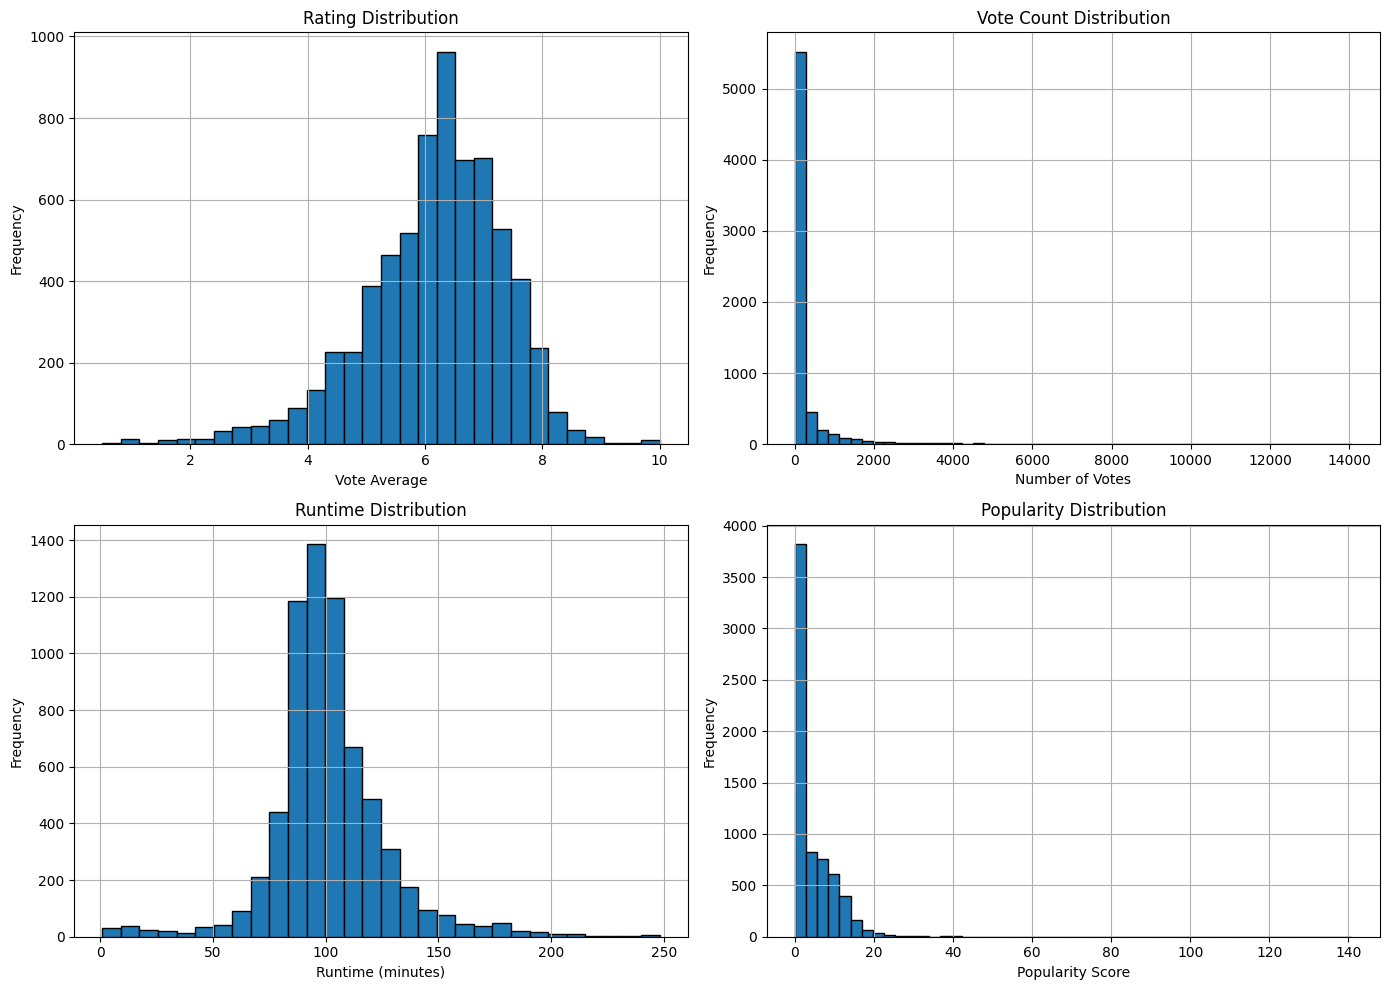

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

df_clean['vote_average'].hist(bins=30, ax=axes[0,0], edgecolor='black')
axes[0,0].set_title('Rating Distribution')
axes[0,0].set_xlabel('Vote Average')
axes[0,0].set_ylabel('Frequency')

df_clean['vote_count'].hist(bins=50, ax=axes[0,1], edgecolor='black')
axes[0,1].set_title('Vote Count Distribution')
axes[0,1].set_xlabel('Number of Votes')
axes[0,1].set_ylabel('Frequency')

df_clean['runtime'].hist(bins=30, ax=axes[1,0], edgecolor='black')
axes[1,0].set_title('Runtime Distribution')
axes[1,0].set_xlabel('Runtime (minutes)')
axes[1,0].set_ylabel('Frequency')

df_clean['popularity'].hist(bins=50, ax=axes[1,1], edgecolor='black')
axes[1,1].set_title('Popularity Distribution')
axes[1,1].set_xlabel('Popularity Score')
axes[1,1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

Distribution Analysis


- **Ratings:** Normal distribution centered around 6-7, most movies rated between 5-8. Few extremely bad (<3) or perfect (>9) movies.

- **Vote Count:** Heavily right-skewed - most movies have very few votes (<500), while a small number are extremely popular (>5000 votes).

- **Runtime:** Normal distribution centered around 90-100 minutes, which is typical for feature films. Our cleaning successfully removed outliers.

- **Popularity:** Extremely right-skewed - vast majority of movies have low popularity (<10), with only a handful of blockbusters driving the high end. Might need log transformation for modeling.

We have mostly "average" rated movies with moderate engagement, and a small subset of highly popular blockbusters.

Let's look at content features - genres, actors, directors

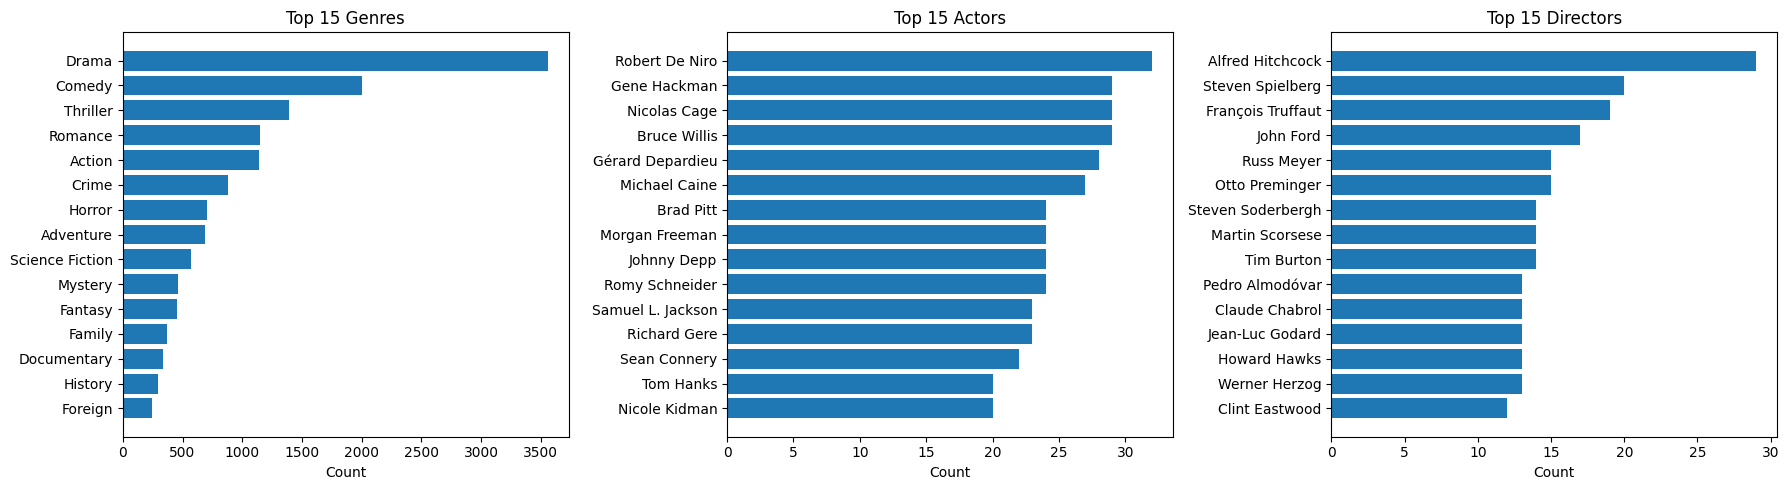

In [ ]:
all_genres = [genre for genres in df_clean['genres_list'] for genre in genres]
genre_counts = Counter(all_genres).most_common(15)

all_actors = [actor for cast in df_clean['cast_list'] for actor in cast]
actor_counts = Counter(all_actors).most_common(15)

director_counts = df_clean['director'].value_counts().head(15)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

genres, g_counts = zip(*genre_counts)
axes[0].barh(genres, g_counts)
axes[0].set_title('Top 15 Genres')
axes[0].set_xlabel('Count')
axes[0].invert_yaxis()

actors, a_counts = zip(*actor_counts)
axes[1].barh(actors, a_counts)
axes[1].set_title('Top 15 Actors')
axes[1].set_xlabel('Count')
axes[1].invert_yaxis()

axes[2].barh(director_counts.index, director_counts.values)
axes[2].set_title('Top 15 Directors')
axes[2].set_xlabel('Count')
axes[2].invert_yaxis()

plt.tight_layout()
plt.show()

Content Feature Analysis

**Genres:**
- Drama dominates (~3500 movies), followed by Comedy and Thriller
- Action/Adventure less common than expected
- Dataset skews toward serious/dramatic content

**Actors:**
- Robert De Niro, Nicolas Cage, Bruce Willis lead with 30+ movies each
- actors from 80s-90s era dominate (De Niro, Hackman, Willis)
- Shows dataset has good coverage of mainstream Hollywood

**Directors:**
- Alfred Hitchcock tops the list (~30 films) - classic cinema well-represented
- Mix of old masters (Hitchcock, Ford) and modern directors (Spielberg, Burton)

Content-based recommendations can leverage these popular actors/directors to find similar movies. Genre diversity is good but Drama-heavy.

Let's look at temporal trends - how movies evolved over time

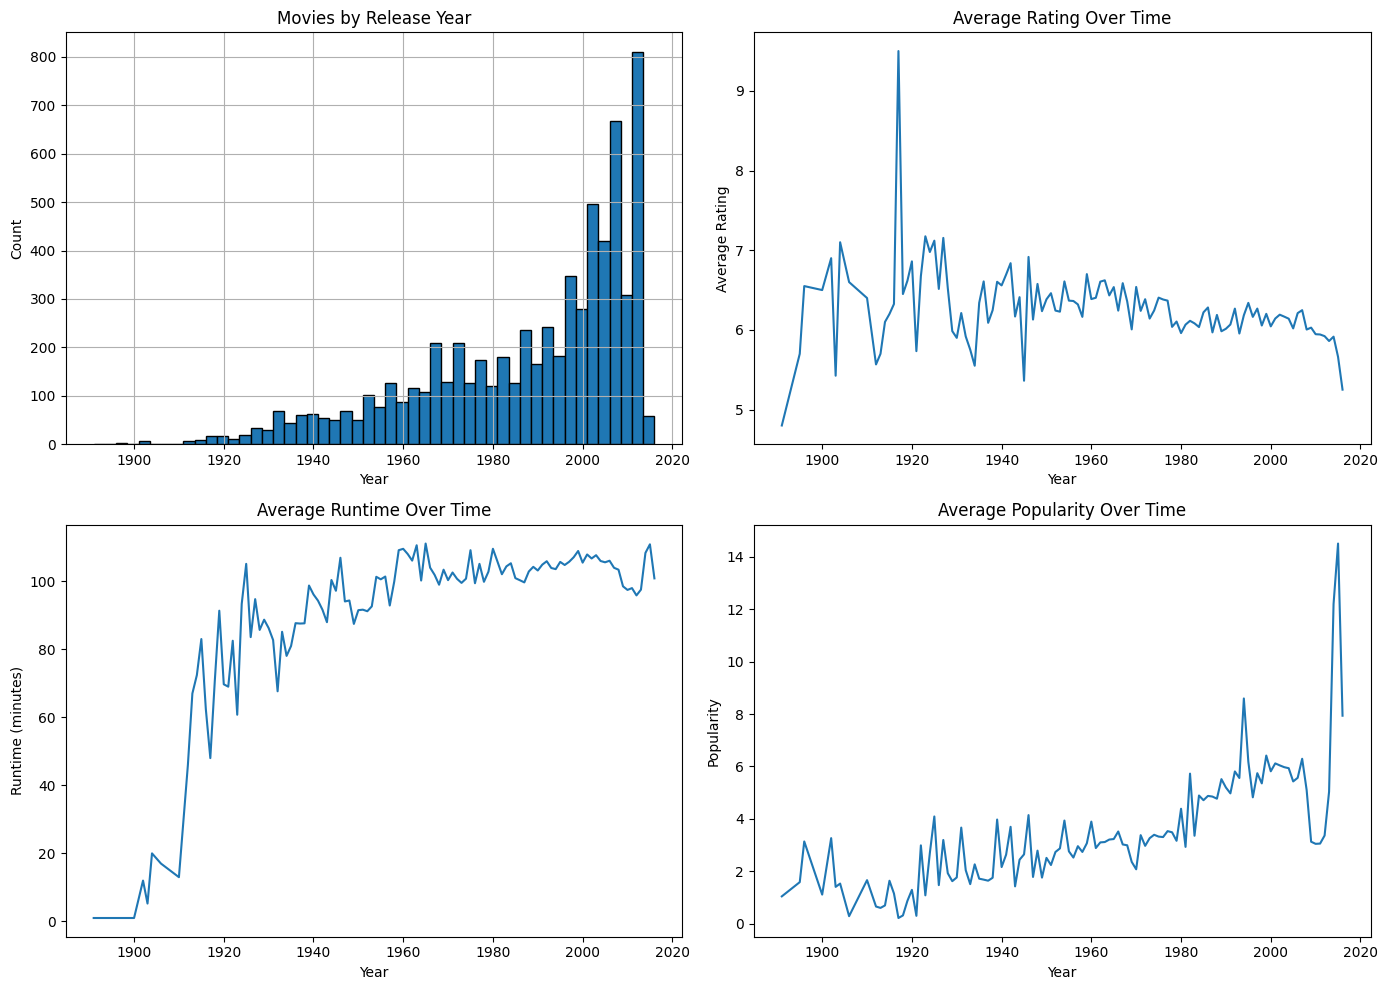

In [ ]:
df_clean['release_year'] = df_clean['release_date'].dt.year

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

df_clean['release_year'].hist(bins=50, ax=axes[0,0], edgecolor='black')
axes[0,0].set_title('Movies by Release Year')
axes[0,0].set_xlabel('Year')
axes[0,0].set_ylabel('Count')

year_avg_rating = df_clean.groupby('release_year')['vote_average'].mean()
axes[0,1].plot(year_avg_rating.index, year_avg_rating.values)
axes[0,1].set_title('Average Rating Over Time')
axes[0,1].set_xlabel('Year')
axes[0,1].set_ylabel('Average Rating')

year_avg_runtime = df_clean.groupby('release_year')['runtime'].mean()
axes[1,0].plot(year_avg_runtime.index, year_avg_runtime.values)
axes[1,0].set_title('Average Runtime Over Time')
axes[1,0].set_xlabel('Year')
axes[1,0].set_ylabel('Runtime (minutes)')

year_popularity = df_clean.groupby('release_year')['popularity'].mean()
axes[1,1].plot(year_popularity.index, year_popularity.values)
axes[1,1].set_title('Average Popularity Over Time')
axes[1,1].set_xlabel('Year')
axes[1,1].set_ylabel('Popularity')

plt.tight_layout()
plt.show()

Temporal Trends

**Movie Volume:**
- Exponential growth from 1990s onward, peaking around 2015-2017
- Sharp drop after 2017 (likely dataset cutoff or incomplete recent data)
- Very few movies pre-1920s

**Average Ratings Over Time:**
- Early films (pre-1920) rated lower (~5-6) - survivorship bias, only "notable" films recorded
- Golden age spike around 1920 (~9.5 rating) - likely few highly-acclaimed classics
- Stable around 6-7 from 1950s onward
- Slight decline in recent years (2010+) - rating inflation or more critical audiences

**Runtime Evolution:**
- Started very short (<20 min) in early 1900s - silent film era
- Jumped to 90-100 min by 1920s and stabilized
- Stayed consistent around 100-110 min since 1960s
- Modern movies maintain traditional feature-length format

**Popularity Trends:**
- Low and stable (~2-4) from 1900s-2000s
- Sharp increase starting 2000s, peaking 2010-2017
- Reflects modern marketing, social media era, and blockbuster culture
- Recent drop-off likely incomplete data

Dataset heavily weighted toward modern films (2000-2017). Older classics well-represented but fewer in number.

Let's look at correlations between numerical features

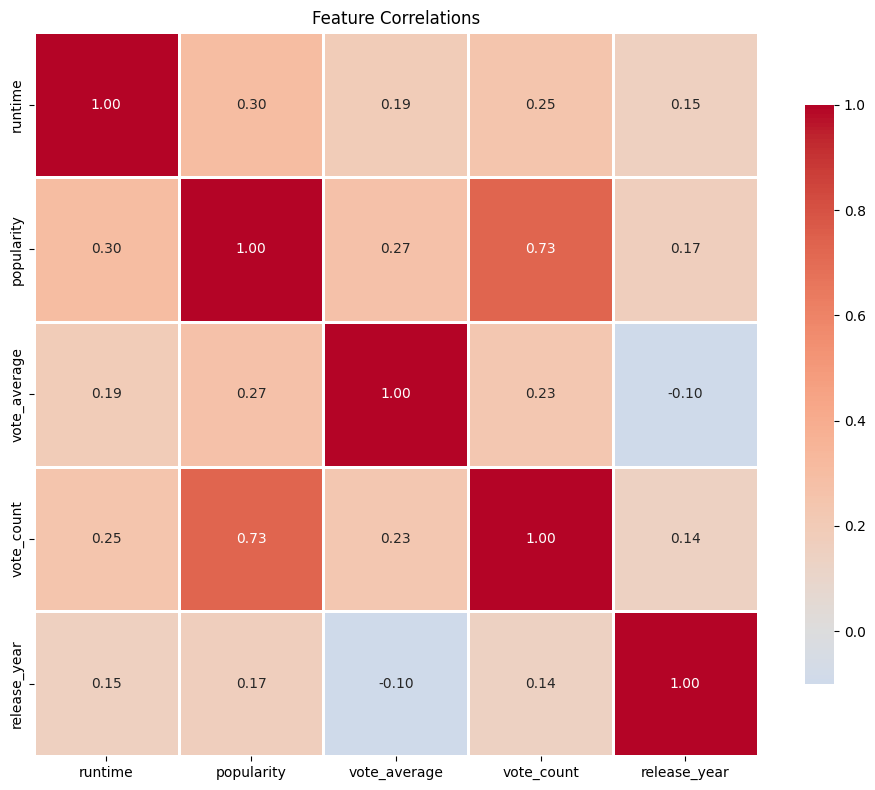

In [ ]:
numerical_features = ['runtime', 'popularity', 'vote_average', 'vote_count', 'release_year']
correlation_matrix = df_clean[numerical_features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Feature Correlations')
plt.tight_layout()
plt.show()

Correlation analysis:

**Strong Correlations:**
- **Popularity <-> Vote Count (0.73):** Very strong positive - popular movies get more votes, which is expected
- **Runtime <-> Popularity (0.30):** Weak positive - longer movies slightly more popular

**Weak/Interesting Correlations:**
- **Vote Average <-> Popularity (0.27):** Weak - being popular doesn't mean high quality
- **Vote Average <-> Vote Count (0.23):** Weak - more votes doesn't guarantee better rating
- **Vote Average <-> Release Year (-0.10):** Slight negative - newer movies rated slightly lower (rating inflation or nostalgia bias?)

**No Strong Correlations with Quality:**
- Runtime, popularity, vote count don't strongly predict rating
- Suggests movie quality is subjective and not driven by these metrics alone

Based on this we can't rely solely on popularity/vote count to recommend "good" movies. Need content-based features (genres, cast, keywords) to match user preferences. Collaborative filtering (user-item interactions) will be crucial

Before building the recomendation system, we will drop columns we won't use

In [ ]:
numeric_features = df_clean[['runtime', 'vote_average', 'popularity']].values

cols_to_drop_final = [
    'imdb_id',
    'production_country_iso', 'spoken_language_iso',
    'original_language'
]

df_clean = df_clean.drop(columns=cols_to_drop_final)

# 3) LSH & Similar Items

Given a movie, let's find the most similar movies efficiently using MinHash + LSH

**Approach:**
1. Extract features from each movie (genres, cast, director, keywords, collection)
2. Create MinHash signatures to efficiently represent movies
3. Use LSH to find candidate similar pairs without comparing all movies
4. Build recommender function that returns top-N similar movies

We implement LSH first as a lightweight, interpretable baseline using explicit features. Clustering follows as a more sophisticated approach that captures semantic similarity through embeddings.

In [ ]:
# for top companies we use only the top 30, for more meaningful insight
top_companies = df_clean[df_clean['production_company'] != '']['production_company'].value_counts().head(30).index.tolist()

In [ ]:
top_companies[:10]

['Paramount Pictures',
 'Universal Pictures',
 'Twentieth Century Fox Film Corporation',
 'Metro-Goldwyn-Mayer (MGM)',
 'Warner Bros.',
 'Columbia Pictures Corporation',
 'United Artists',
 'Columbia Pictures',
 'New Line Cinema',
 'Miramax Films']

In [ ]:
def create_movie_features(row):
    features = set()

    for genre in row['genres_list']:
        features.add(f"genre:{genre}")

    for actor in row['cast_list']:
        features.add(f"actor:{actor}")

    if row['director']:
        features.add(f"director:{row['director']}")

    for keyword in row['keywords_list']:
        features.add(f"keyword:{keyword}")

    if row['collection_name']:
        features.add(f"collection:{row['collection_name']}")

    if row['production_company'] and row['production_company'] in top_companies:
        features.add(f"studio:{row['production_company']}")

    decade = (row['release_year'] // 10) * 10
    features.add(f"decade:{decade}s")

    return features

In [ ]:
df_clean['feature_set'] = df_clean.apply(create_movie_features, axis=1)

# Test
sample = df_clean.iloc[0]
print(f"\nMovie: {sample['title']}")
print(f"Number of features: {len(sample['feature_set'])}")
print(f"Sample features: {list(sample['feature_set'])[:12]}")


Movie: Toy Story
Number of features: 20
Sample features: ['actor:Jim Varney', 'keyword:boy next door', 'keyword:toy', 'actor:Wallace Shawn', 'keyword:boy', 'genre:Family', 'keyword:jealousy', 'decade:1990s', 'genre:Animation', 'keyword:friends', 'keyword:toy comes to life', 'keyword:friendship']


In [ ]:
def create_shingles(feature_set, q=1):
    """
    Create q-shingles from features
    q=1: individual features
    q=2+: feature combinations
    """
    if q == 1:
        return feature_set

    features_list = sorted(list(feature_set))
    shingles = set()

    for i in range(len(features_list) - q + 1):
        shingle = tuple(features_list[i:i+q])
        shingles.add(shingle)

    return shingles

In [ ]:
def minhash_signature(shingles, num_hashes=100):
    signature = []

    for seed in range(num_hashes):
        min_hash = float('inf')

        for shingle in shingles:
            shingle_str = str(shingle)
            hash_value = mmh3.hash(shingle_str, seed)
            min_hash = min(min_hash, hash_value)

        signature.append(min_hash)

    return signature

all_signatures = {}
q = 1
num_hashes = 100

for idx in range(len(df_clean)):
    movie_id = df_clean.iloc[idx]['id']
    shingles = create_shingles(df_clean.iloc[idx]['feature_set'], q=q)
    signature = minhash_signature(shingles, num_hashes=num_hashes)
    all_signatures[movie_id] = signature

print(f"signatures created: {len(all_signatures)}")

signatures created: 6721


In [ ]:
def lsh_buckets(signatures_dict, b=50, r=2):

    """
    LSH: split signatures into b bands of r rows
    movies hashing to same bucket in any band = candidates
    """

    k = b * r
    buckets = {}

    for movie_id, signature in signatures_dict.items():
        for band_idx in range(b):
            start = band_idx * r
            end = start + r
            band = tuple(signature[start:end])
            band_hash = hash(band)

            key = (band_idx, band_hash)
            if key not in buckets:
                buckets[key] = []
            buckets[key].append(movie_id)

    candidate_pairs = set()
    for bucket_movies in buckets.values():
        if len(bucket_movies) > 1:
            for i in range(len(bucket_movies)):
                for j in range(i+1, len(bucket_movies)):
                    pair = tuple(sorted([bucket_movies[i], bucket_movies[j]]))
                    candidate_pairs.add(pair)

    return candidate_pairs

candidates = lsh_buckets(all_signatures, b=50, r=2)

total_possible = len(df_clean) * (len(df_clean) - 1) // 2

reduction = (1 - len(candidates) / total_possible) * 100

print(f"candidate pairs: {len(candidates):,}")
print(f"total possible: {total_possible:,}")
print(f"reduction: {reduction:.1f}%")

candidate pairs: 796,842
total possible: 22,582,560
reduction: 96.5%


In [ ]:
def estimate_jaccard_from_signatures(sig1, sig2):
    matches = sum(1 for i in range(len(sig1)) if sig1[i] == sig2[i])
    return matches / len(sig1)

In [ ]:
def recommend_movies(movie_title, top_n=10):
    movie_row = df_clean[df_clean['title'] == movie_title]
    if len(movie_row) == 0:
        print(f"movie '{movie_title}' not found")
        return []

    movie_id = movie_row.iloc[0]['id']
    movie_sig = all_signatures[movie_id]

    similar_movies = []
    for id1, id2 in candidates:
        if id1 == movie_id:
            other_id = id2
        elif id2 == movie_id:
            other_id = id1
        else:
            continue

        other_sig = all_signatures[other_id]
        similarity = estimate_jaccard_from_signatures(movie_sig, other_sig)
        other_title = df_clean[df_clean['id'] == other_id].iloc[0]['title']
        similar_movies.append((other_title, similarity))

    similar_movies.sort(key=lambda x: x[1], reverse=True)
    return similar_movies[:top_n]

In [ ]:
test_movies = ['The Dark Knight', 'Jumanji', 'Forrest Gump']

for movie in test_movies:
    recs = recommend_movies(movie, top_n=5)
    print(f"recommendations for '{movie}':\n")
    for i, (title, sim) in enumerate(recs, 1):
        print(f"{i}. {title} ({sim:.3f})")
    print()

recommendations for 'The Dark Knight':

1. Batman Begins (0.370)
2. Batman & Robin (0.210)
3. Batman (0.190)
4. Batman Returns (0.150)
5. Dick Tracy (0.130)

recommendations for 'Jumanji':

1. Jack and the Beanstalk (0.190)
2. Arthur and the Revenge of Maltazard (0.180)
3. The Fairy King Of Ar (0.180)
4. Tom Thumb (0.180)
5. Hook (0.170)

recommendations for 'Forrest Gump':

1. What's Eating Gilbert Grape (0.130)
2. When Harry Met Sally... (0.130)
3. Notting Hill (0.110)
4. Homeward Bound: The Incredible Journey (0.110)
5. The Private Lives of Pippa Lee (0.110)



We can check what makes these movies similar

In [ ]:
def explain_similarity(movie1_title, movie2_title):
    """show which features two movies have in common"""
    movie1_features = df_clean[df_clean['title'] == movie1_title].iloc[0]['feature_set']
    movie2_features = df_clean[df_clean['title'] == movie2_title].iloc[0]['feature_set']

    common = movie1_features & movie2_features
    return common

for movie in test_movies:
    print(f"\nexplaining '{movie}':\n")
    recs = recommend_movies(movie, top_n=3)
    for title, sim in recs:
        common = explain_similarity(movie, title)
        print(f"{title}")
        print(f"  common features: {list(common)}")
        print()


explaining 'The Dark Knight':

Batman Begins
  common features: ['director:Christopher Nolan', 'genre:Drama', 'genre:Action', 'keyword:based on comic', 'keyword:gotham city', 'genre:Crime', 'keyword:crime fighter', 'collection:The Dark Knight Collection', 'keyword:tragic hero', 'keyword:super powers', 'decade:2000s', 'actor:Christian Bale', 'keyword:vigilante', 'keyword:superhero', 'actor:Michael Caine', 'keyword:dc comics', 'actor:Gary Oldman', 'keyword:secret identity']

Batman & Robin
  common features: ['genre:Action', 'keyword:gotham city', 'genre:Crime', 'keyword:crime fighter', 'keyword:super powers', 'keyword:superhero', 'keyword:dc comics']

Batman
  common features: ['genre:Action', 'keyword:gotham city', 'keyword:crime fighter', 'keyword:super powers', 'keyword:superhero', 'keyword:dc comics']


explaining 'Jumanji':

Jack and the Beanstalk
  common features: ['genre:Family', 'genre:Adventure', 'genre:Fantasy']

Arthur and the Revenge of Maltazard
  common features: ['genre

Recommendations are sensible - Batman movies cluster together, family adventures match Jumanji, romantic comedies match Forrest Gump. Common features show why movies are similar (shared director, actors, genres, themes).

# 3) Clustering

In [ ]:
!pip install -U sentence-transformers -q

In [ ]:
import os

# Third-party libraries
import numpy as np
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity

# Other
from numpy import hstack

In [ ]:
def extract_genres(feature_set):
    if not isinstance(feature_set, (set, list)):
        return []
    genres = []
    for item in feature_set:
        if isinstance(item, str) and item.startswith("genre:"):
            genres.append(item.replace("genre:", "").strip())
    return genres

df_clean['genre_list'] = df_clean['feature_set'].apply(extract_genres)

In [ ]:
mlb = MultiLabelBinarizer()
genre_onehot = mlb.fit_transform(df_clean['genre_list'])

print(genre_onehot.shape)  # (n_movies, n_genres)
mlb.classes_

(6721, 20)


array(['Action', 'Adventure', 'Animation', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Family', 'Fantasy', 'Foreign', 'History',
       'Horror', 'Music', 'Mystery', 'Romance', 'Science Fiction',
       'TV Movie', 'Thriller', 'War', 'Western'], dtype=object)

In [ ]:
numeric_features = np.array(numeric_features)
numeric_features.shape

(6721, 3)

In [ ]:
numeric_features = np.array(numeric_features)
print(numeric_features.shape)
simple_features = hstack([
    genre_onehot,     # (n, G)
    numeric_features    # (n, M)
])

print(simple_features.shape)

(6721, 3)
(6721, 23)


In [ ]:
k = 5
kmeans_ns = KMeans(n_clusters=k, random_state=42, n_init='auto')
cluster_labels_ns = kmeans_ns.fit_predict(simple_features)

df_clean['cluster_no_emb_no_sent'] = cluster_labels_ns

In [ ]:
sil = silhouette_score(simple_features, cluster_labels_ns)
print("Silhouette (no embeddings, no sentiment):", sil)

Silhouette (no embeddings, no sentiment): 0.4223527585162091


Creating a combined text field for each moview - **text_for_embedding**, so we can feed it into an embedding model

In [ ]:
def build_movie_text(row):
    parts = []

    if 'overview' in row and isinstance(row['overview'], str):
        parts.append(row['overview'])

    if 'feature_set' in row and isinstance(row['feature_set'], (set, list)):
        parts.append(" ".join(sorted(map(str, row['feature_set']))))

    if not parts and 'title' in row and isinstance(row['title'], str):
        parts.append(row['title'])

    return " ".join(parts)

df_clean['text_for_embedding'] = df_clean.apply(build_movie_text, axis=1)

df_clean[['title', 'text_for_embedding']].head()

,title,text_for_embedding
0,Toy Story,"Led by Woody, Andy's toys live happily in his ..."
1,Jumanji,When siblings Judy and Peter discover an encha...
2,Heat,"Obsessive master thief, Neil McCauley leads a ..."
3,GoldenEye,James Bond must unmask the mysterious head of ...
4,Cutthroat Island,"Morgan Adams and her slave, William Shaw, are ..."


768-dimensional SBERT embeddings are needed because they provide strong semantic understanding. They can be used for tasks such as similarity, clustering, and recommendations, which fits our assignment. (The idea of using an SBERT embedding model came from an exploration session using an AI tool - specifically ChatGPT 5.1.)

In [ ]:
texts = df_clean['text_for_embedding'].tolist()
emb_path = "sbert_embeddings_384.npy"

if os.path.exists(emb_path):
    embeddings = np.load(emb_path)
else:
    model = SentenceTransformer("all-MiniLM-L6-v2")
    embeddings = model.encode(texts, convert_to_numpy=True, batch_size=128)
    np.save(emb_path, embeddings)

print(embeddings.shape)

(6721, 384)


Sentiment polarity (VADER) is an external sentiment analysis tool that assigns sentiment scores to a piece of text. It returns four values: positive, neutral, negative, and compound. When combined with SBERT, it strengthens the model because sentiment becomes an additional feature.


In [ ]:
nltk.download('vader_lexicon')

sid = SentimentIntensityAnalyzer()

def compute_sentiment(text):
    if not isinstance(text, str) or text.strip() == "":
        return 0.0
    scores = sid.polarity_scores(text)
    return scores['compound']
df_clean['sentiment'] = df_clean['overview'].apply(compute_sentiment)
sentiment_vec = df_clean['sentiment'].values.reshape(-1, 1)

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Combining everything

In [ ]:
from sklearn.preprocessing import StandardScaler
import numpy as np # Ensure numpy is imported for hstack

# The 'numeric_features' variable comes from a previous cell and should already be a 2D numpy array.
# We assign it to a new variable for clarity before scaling.
raw_numeric_features_for_scaling = numeric_features
print("raw numeric_features shape:", raw_numeric_features_for_scaling.shape)

scaler = StandardScaler()
numeric_features_scaled = scaler.fit_transform(raw_numeric_features_for_scaling)
print("scaled numeric_features shape:", numeric_features_scaled.shape)

# Ensure embeddings is a dense numpy array before hstack
# It could be a sparse matrix (from TfidfVectorizer) or a dense array (from SBERT).
# numpy.hstack handles dense arrays more predictably.
if hasattr(embeddings, 'toarray'):
    embeddings_to_hstack = embeddings.toarray()
else:
    embeddings_to_hstack = embeddings

# All inputs to hstack should now be dense 2D numpy arrays
print("embeddings (final) shape:", embeddings_to_hstack.shape)
print("sentiment_vec shape:", sentiment_vec.shape)
print("genre_onehot shape:", genre_onehot.shape)
print("numeric_features (final) shape:", numeric_features_scaled.shape)

features_fused = np.hstack([embeddings_to_hstack, sentiment_vec, genre_onehot, numeric_features_scaled])

print("features_fused shape:", features_fused.shape)


raw numeric_features shape: (6721, 3)
scaled numeric_features shape: (6721, 3)
embeddings (final) shape: (6721, 384)
sentiment_vec shape: (6721, 1)
genre_onehot shape: (6721, 20)
numeric_features (final) shape: (6721, 3)
features_fused shape: (6721, 408)


In [ ]:
!pip install umap-learn

Original shape: (6721, 408)
Reduced shape (PCA): (6721, 80)
Calculating metrics for optimal K...


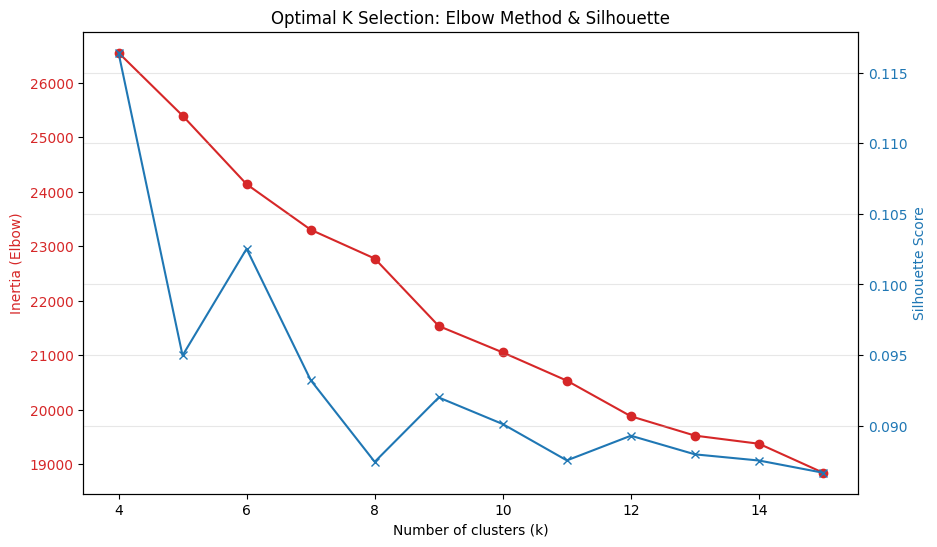


Manual K selection for better granularity: 10
Cluster sizes:
cluster
0     230
1     639
2      34
3     893
4    1108
5    1182
6     782
7     654
8     878
9     321
Name: count, dtype: int64

==================== CLUSTER INTERPRETATION ====================

>>> CLUSTER 0 (n=230)
Themes: short, silent film, woman director, stand-up comedy, holiday, dog
Genres: Comedy, Animation, Drama, Documentary
Rating: 6.49
Movies: ['Some Folks Call It a Sling Blade', 'A Close Shave', 'The Wrong Trousers', 'A Grand Day Out', 'See the Sea']

>>> CLUSTER 1 (n=639)
Themes: dystopia, duringcreditsstinger, violence, murder, revenge, based on novel
Genres: Action, Thriller, Adventure, Comedy
Rating: 6.38
Movies: ['Toy Story', 'Jumanji', 'GoldenEye', 'Cutthroat Island', 'Get Shorty']

>>> CLUSTER 2 (n=34)
Themes: aftercreditsstinger, dystopia, based on novel, loss of father, witch, magic
Genres: Adventure, Drama, Action, Fantasy
Rating: 7.83
Movies: ['Star Wars', 'Pulp Fiction', 'The Shawshank Redempti

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP coordinates added to df_clean['umap_x'] and ['umap_y']


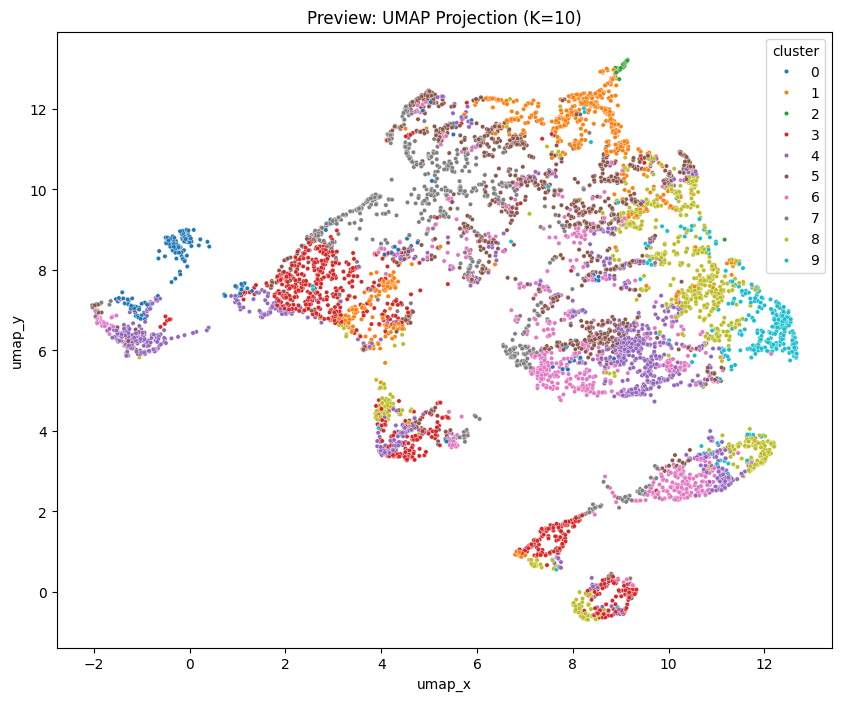

In [ ]:
# This block implements the revised clustering pipeline.
# We use PCA for dimensionality reduction, select K via Elbow/Silhouette analysis,
# and generate descriptive statistics for each cluster.

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import numpy as np

#  STEP 1: Dimensionality Reduction (PCA)
# Reducing dimensionality from ~800 features to principal components retaining 95% variance.
# This removes noise and helps K-Means perform more accurately by mitigating the curse of dimensionality.
pca = PCA(n_components=0.95, random_state=42)
features_pca = pca.fit_transform(features_fused)

print(f"Original shape: {features_fused.shape}")
print(f"Reduced shape (PCA): {features_pca.shape}")

#  STEP 2: Find Optimal K (Elbow & Silhouette)
inertia = []
silhouette_scores = []
K_range = range(4, 16)  # Testing cluster counts from 4 to 15

print("Calculating metrics for optimal K...")
for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init='auto')
    labels = km.fit_predict(features_pca)
    inertia.append(km.inertia_)
    silhouette_scores.append(silhouette_score(features_pca, labels))

# Plotting metrics for the report
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:red'
ax1.set_xlabel('Number of clusters (k)')
ax1.set_ylabel('Inertia (Elbow)', color=color)
ax1.plot(K_range, inertia, marker='o', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Silhouette Score', color=color)
ax2.plot(K_range, silhouette_scores, marker='x', color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title("Optimal K Selection: Elbow Method & Silhouette")
plt.grid(True, alpha=0.3)
plt.show()



#  STEP 3: Final Clustering
# NOTE: The graph showed K=4 has the highest score, but 4 clusters is too broad
# for a recommendation system (likely just huge generic groups).
# We manually override this to K=10 to find more specific sub-genres (niches).
best_k = 10
print(f"\nManual K selection for better granularity: {best_k}")

kmeans_final = KMeans(n_clusters=best_k, random_state=42, n_init='auto')
cluster_labels = kmeans_final.fit_predict(features_pca)

# Save labels
df_clean['cluster'] = cluster_labels
print("Cluster sizes:")
print(df_clean['cluster'].value_counts().sort_index())

#  STEP 4: Cluster Interpretation
def interpret_clusters(df, n_clusters):
    print(f"\n{'='*20} CLUSTER INTERPRETATION {'='*20}")

    # Check if 'vote_average' exists, otherwise try to find a rating column
    rating_col = 'vote_average'
    if rating_col not in df.columns:
        # Try to guess alternative names if they exist
        possible_names = ['rating', 'score', 'vote_avg']
        for name in possible_names:
            if name in df.columns:
                rating_col = name
                break
        else:
            rating_col = None # Column not found

    for c in range(n_clusters):
        subset = df[df['cluster'] == c]

        # Get Top Genres
        genres = [g for sublist in subset['genres_list'] for g in sublist]
        top_genres = [g[0] for g in Counter(genres).most_common(4)]

        # Get Top Keywords
        keywords = [k for sublist in subset['keywords_list'] for k in sublist]
        top_keywords = [k[0] for k in Counter(keywords).most_common(6)]

        # Get Rating (safely)
        if rating_col:
            avg_rating = subset[rating_col].mean()
            rating_str = f"{avg_rating:.2f}"
        else:
            rating_str = "N/A"

        print(f"\n>>> CLUSTER {c} (n={len(subset)})")
        print(f"Themes: {', '.join(top_keywords)}")
        print(f"Genres: {', '.join(top_genres)}")
        print(f"Rating: {rating_str}")
        print(f"Movies: {subset['title'].head(5).tolist()}")

interpret_clusters(df_clean, best_k)


#  STEP 5: Prepare for Visualization (UMAP)
# We calculate coordinates here, but the final polishing of plots can be handled by Member D.
try:
    import umap
    print("\nCalculating UMAP 2D projection...")
    reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1)
    embedding_2d = reducer.fit_transform(features_pca)

    df_clean['umap_x'] = embedding_2d[:, 0]
    df_clean['umap_y'] = embedding_2d[:, 1]
    print("UMAP coordinates added to df_clean['umap_x'] and ['umap_y']")

    # Quick preview (to ensure clusters are well-separated)
    plt.figure(figsize=(10, 8))
    sns.scatterplot(data=df_clean, x='umap_x', y='umap_y', hue='cluster', palette='tab10', s=10)
    plt.title(f"Preview: UMAP Projection (K={best_k})")
    plt.show()

except ImportError:
    print("UMAP not installed. Run: !pip install umap-learn")

In [ ]:

# PART 5: THE RECOMMENDATION ENGINE
def recommend_by_cluster(movie_title, df=df_clean, top_n=5):
    """
    Safely recommends movies from the same cluster.
    Checks which columns exist to avoid KeyErrors.
    """
    # 1. Find the movie

    movie_row = df[df['title'].astype(str).str.lower() == movie_title.lower()]

    if len(movie_row) == 0:
        return f"Movie '{movie_title}' not found in the dataset."

    # 2. Identify its cluster
    target_cluster = movie_row['cluster'].values[0]
    print(f"Movie: '{movie_row['title'].values[0]}' belongs to Cluster {target_cluster}")

    # 3. Get all movies in this cluster
    cluster_movies = df[df['cluster'] == target_cluster].copy()

    # 4. Sorting Logic (Check what columns we actually have)
    sort_cols = []
    if 'vote_average' in df.columns:
        sort_cols.append('vote_average')
    if 'popularity' in df.columns:
        sort_cols.append('popularity')

    if sort_cols:
        # Sort by available quality metrics
        recommendations = cluster_movies.sort_values(by=sort_cols, ascending=False)
    else:

        recommendations = cluster_movies

    # 5. Remove the movie itself
    recommendations = recommendations[recommendations['title'].str.lower() != movie_title.lower()]

    # 6. Return only columns that actually exist
    cols_to_show = ['title', 'genres_list']
    if 'vote_average' in df.columns:
        cols_to_show.append('vote_average')

    return recommendations[cols_to_show].head(top_n)

# TEST THE SYSTEM
print("--- TEST: Recommendations for 'Toy Story' ---")
# Toy Story is usually Cluster 2 (Animation/Family)
print(recommend_by_cluster("Toy Story"))

print("\n--- TEST: Recommendations for 'Pulp Fiction' ---")
# Pulp Fiction is usually Cluster 6 (Cult/Dark)
print(recommend_by_cluster("Pulp Fiction"))

print("\n--- TEST: Recommendations for 'GoldenEye' ---")
# GoldenEye is usually Cluster 4 (Action)
print(recommend_by_cluster("GoldenEye"))

--- TEST: Recommendations for 'Toy Story' ---
Movie: 'Toy Story' belongs to Cluster 1
                        title                           genres_list  \
309   The Empire Strikes Back  [Adventure, Action, Science Fiction]   
827         Princess Mononoke       [Adventure, Fantasy, Animation]   
2347     Howl's Moving Castle       [Fantasy, Animation, Adventure]   
354               The Shining                    [Horror, Thriller]   
16                      Se7en            [Crime, Mystery, Thriller]   

      vote_average  
309            8.2  
827            8.2  
2347           8.2  
354            8.1  
16             8.1  

--- TEST: Recommendations for 'Pulp Fiction' ---
Movie: 'Pulp Fiction' belongs to Cluster 2
                         title                       genres_list  vote_average
87    The Shawshank Redemption                    [Drama, Crime]           8.5
202              The Godfather                    [Drama, Crime]           8.5
3060           The Dark Knight 

K-Means requires choosing K upfront. But what if we want to explore how movies naturally group at different levels of similarity?

Hierarchical clustering builds a tree (dendrogram) showing how movies merge step-by-step - from individual films up to broad categories. This helps us:
1. Validate our K=10 choice by seeing if natural groupings exist around that level
2. Understand which clusters are closely related

# 3.1) Hierarchical clustering

Computing Hierarchical Clustering (Ward Linkage)...


/tmp/ipython-input-1260923923.py:26: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/tmp/ipython-input-1260923923.py:27: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig('dendrogram.png', dpi=300) # Save for report
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


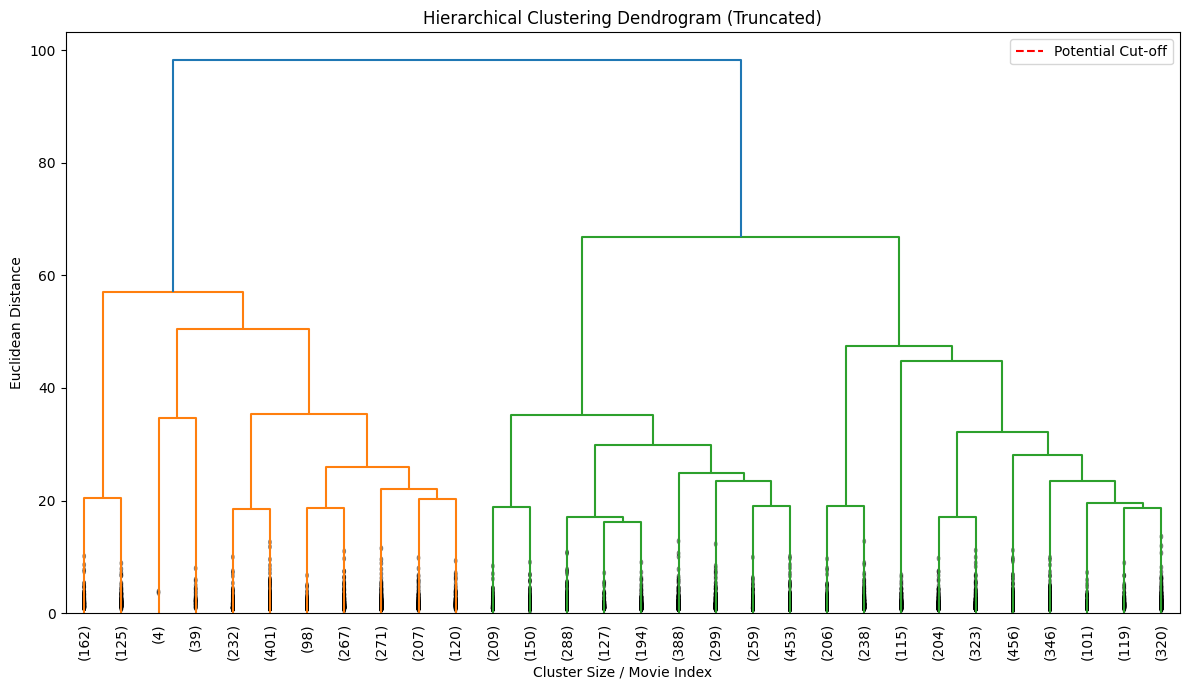

Dendrogram saved as 'dendrogram.png'.


In [ ]:
# PART 6: HIERARCHICAL CLUSTERING
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering

print("Computing Hierarchical Clustering (Ward Linkage)...")
# We use Ward's method as it minimizes variance within clusters (good for quantitatve data)
linkage_matrix = sch.linkage(features_pca, method='ward')

# Plotting the Dendrogram
plt.figure(figsize=(12, 7))
plt.title('Hierarchical Clustering Dendrogram (Truncated)')
plt.xlabel('Cluster Size / Movie Index')
plt.ylabel('Euclidean Distance')

# We truncate the tree to show only the top 30 branches for readability
dendrogram = sch.dendrogram(
    linkage_matrix,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=30,                   # show only the last 30 merges
    leaf_rotation=90.,
    leaf_font_size=10.,
    show_contracted=True    # to get a distribution impression in truncated branches
)
plt.axhline(y=200, color='r', linestyle='--', label="Potential Cut-off") # Optional line
plt.legend()
plt.tight_layout()
plt.savefig('dendrogram.png', dpi=300) # Save for report
plt.show()

print("Dendrogram saved as 'dendrogram.png'.")

# 4) Collaborative Filtering

To ensure we only consider ratings for movies in our clean dataframe, we filter out all other ratings.

In [ ]:
movie_ids_in_clean = set(movies_with_links['movieId'])
ratings_filtered = ratings[ratings['movieId'].isin(movie_ids_in_clean)]
print(f"ratings: {len(ratings_filtered):,}")
print(f"unique users: {ratings_filtered['userId'].nunique()}")
print(f"unique movies: {ratings_filtered['movieId'].nunique()}")

ratings: 14,661,067
unique users: 267689
unique movies: 6883


In [ ]:
print(ratings_filtered.isnull().sum())

print(ratings_filtered.dtypes)

print(f"\nduplicate rows: {ratings_filtered.duplicated().sum()}")

print(f"\nrating range: {ratings_filtered['rating'].min()} to {ratings_filtered['rating'].max()}")

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64
userId         int64
movieId        int64
rating       float64
timestamp      int64
dtype: object

duplicate rows: 0

rating range: 0.5 to 5.0


Importing cosine similarity to achieve a similarity matrix for Collaborative Filtering and preparing dataset.

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

test_ratings = ratings_filtered.head(500000)
user_movie_matrix = test_ratings.pivot_table(index='userId', columns='movieId', values='rating', fill_value= 0)

Since there were some computational issues we only look at 500.000 rows from the ratings dataset. We change NaN to 0 to be able to use cosine similarity, and assume that a rating of 0 means that the user have not watched the movie. This of course means there is chance of false similarities. But given that we will like to include as many users and movies as possible, to make the best recommendations, we will go forward with this approach. We are already hindered by computational issues so implementing methods that remove false similarities would require an even slower running time.


Now we check sparsity of dataset.

In [ ]:
count_blanks = (user_movie_matrix == 0).sum().sum()
count_filled = (user_movie_matrix > 0).sum().sum()
total_count = (user_movie_matrix >= 0).sum().sum()
print(f"total entries: {total_count}")
print(f"valid entries: {count_filled}")
print(f"blank entries: {count_blanks}")
print(f"sparsity in %: {count_blanks/total_count}")
print(f"density in %: {count_filled/total_count}")
print(f"users: {user_movie_matrix.shape[0]}")
print(f"movies: {user_movie_matrix.shape[1]}")


total entries: 35559738
valid entries: 500000
blank entries: 35059738
sparsity in %: 0.9859391539948916
density in %: 0.014060846005108362
users: 8982
movies: 3959


As expected the dataset is very sparse, since we have many ratings spread across a lot of users, that is spread across way fewer movies than users and ratings.
We therefore move forward with item-based collaborative filtering, since we have fewer movies than users. So we are comparing movies to movies.

Finding the similarity matrix of the movies based on user ratings.

In [ ]:
movie_sim = cosine_similarity(user_movie_matrix.T)
movie_sim_df = pd.DataFrame(movie_sim, index = user_movie_matrix.columns, columns = user_movie_matrix.columns)
movie_sim_df.head(10)

movieId,1,2,6,10,15,16,17,18,21,22,...,170397,170821,171089,171767,172289,173963,174393,174793,175777,176271
movieId,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.381896,0.348098,0.343753,0.117223,0.269702,0.323177,0.154049,0.321581,0.175771,...,0.023400,0.018200,0.023400,0.013000,0.020800,0.026001,0.023400,0.020800,0.000000,0.0156
2,0.381896,1.000000,0.258221,0.395934,0.224157,0.257855,0.218362,0.122411,0.315584,0.252425,...,0.030077,0.025064,0.030077,0.000000,0.040102,0.035090,0.030077,0.030077,0.035090,0.0000
6,0.348098,0.258221,1.000000,0.350600,0.135697,0.428681,0.237971,0.190926,0.387052,0.264545,...,0.029051,0.000000,0.029051,0.029051,0.000000,0.041502,0.029051,0.029051,0.029051,0.0000
10,0.343753,0.395934,0.350600,1.000000,0.235675,0.276847,0.204228,0.100170,0.444230,0.254827,...,0.025353,0.000000,0.025353,0.000000,0.000000,0.000000,0.025353,0.029579,0.033805,0.0000
15,0.117223,0.224157,0.135697,0.235675,1.000000,0.141478,0.100783,0.099901,0.172234,0.202770,...,0.105134,0.000000,0.105134,0.000000,0.000000,0.000000,0.105134,0.000000,0.000000,0.0000
16,0.269702,0.257855,0.428681,0.276847,0.141478,1.000000,0.159594,0.176899,0.343043,0.267955,...,0.000000,0.043749,0.000000,0.038888,0.000000,0.043749,0.000000,0.000000,0.000000,0.0000
17,0.323177,0.218362,0.237971,0.204228,0.100783,0.159594,1.000000,0.105114,0.260459,0.153619,...,0.000000,0.000000,0.000000,0.029604,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000
18,0.154049,0.122411,0.190926,0.100170,0.099901,0.176899,0.105114,1.000000,0.143986,0.120377,...,0.072431,0.000000,0.072431,0.000000,0.000000,0.000000,0.072431,0.000000,0.000000,0.0000
21,0.321581,0.315584,0.387052,0.444230,0.172234,0.343043,0.260459,0.143986,1.000000,0.302211,...,0.037145,0.009286,0.037145,0.000000,0.000000,0.000000,0.037145,0.000000,0.000000,0.0000


We find the average amount of ratings users give, to use in our calculation of estimated ratings.

In [ ]:
average_ratings_amount = user_movie_matrix[user_movie_matrix != 0].count(axis="columns").mean()
average_ratings_amount

np.float64(55.666889334224)

Now that we have a similarity table we can calculate a predicted rating of each movie for each user.

In [ ]:
# Finding the movies the user have watched in the respective ratings
def movies_watched(user):
  watched = test_ratings.loc[test_ratings['userId'] == user, "movieId"].tolist()
  scores = test_ratings.loc[test_ratings['userId'] == user, "rating"].tolist()
  return watched, scores

# Retriewing the similarity score between the movies watched and a given movieId.
def similar_movies(user, movie):
  movies_to_keep = movies_watched(user)[0]
  relevant_movies = movie_sim_df.loc[movies_to_keep]
  relevant_movies_scores = relevant_movies.loc[:,movie].tolist()
  relevant_movies = relevant_movies.index.tolist()
  movie_score =[]
  for i in range(len(movies_to_keep)):
    movie_score.append((relevant_movies[i], relevant_movies_scores[i]))
  return movie_score

# Calculates an estimated rating of a movie based on the similarity matrix
def estimated_rating(user, desired_movie_rating):
  user_watched = movies_watched(user)[0]
  df_sim = pd.DataFrame(index = user_watched, columns = ["rating", "sim_score_movie_X"])
  df_sim["rating"] = movies_watched(user)[1]
  df_sim["sim_score_movie_X"] = only_sim_scores = [movie_score[1] for movie_score in similar_movies(user,desired_movie_rating)]
  if len(user_watched) > average_ratings_amount:
    df_sim = df_sim.nlargest(np.round(average_ratings_amount), "sim_score_movie_X")

  mul_sum1 = df_sim["rating"] * df_sim["sim_score_movie_X"]
  df_sim["mul_sum1"] = mul_sum1
  sum1 = df_sim["mul_sum1"].sum()
  sum2 = df_sim["sim_score_movie_X"].sum()

  if sum2 == 0.0:
    return 0
  else:
    return sum1/sum2

user = 10
movies = movies_watched(10)[0]
unwatched_movie = 3
movie_rating = estimated_rating(user, 2)
print(f"Movies user 10 has watched:{movies}")
print("How good of a fit is movie 2 to user 10's taste?")
print(f"Similarity score for watched movies: {similar_movies(10,2)}")
print(f"Rating for movie 2 based on user 10's taste: {movie_rating}")

Movies user 10 has watched:[150, 153, 165, 296, 344, 457, 588, 590, 592, 593]
How good of a fit is movie 2 to user 10's taste?
Similarity score for watched movies: [(150, 0.3779416142266763), (153, 0.3889580584324426), (165, 0.3564600998761577), (296, 0.35482458414539064), (344, 0.4203666369510489), (457, 0.3639687360743086), (588, 0.436946349242735), (590, 0.3415326075638137), (592, 0.4033710628249924), (593, 0.3405926928722963)]
Rating for movie 2 based on user 10's taste: 4.01619045587044


We can now calculate the estimated ratings for all unwatched movies to give the user the best recommendation.

In [ ]:
def collaborative_filtering_recommendations(user, recommendations):
  movies_user_watched = movies_watched(user)[0]
  movie_list = movie_sim_df.drop(movies_user_watched).index.tolist()
  movies = []
  for movie in movie_list:
    est_movie_rating = estimated_rating(user, movie)
    movies.append((movie,est_movie_rating))
  return sorted(movies, key = lambda movie_and_rating: movie_and_rating[1], reverse = True)[0:recommendations + 1]

user_recs = collaborative_filtering_recommendations(10,10)

Let us match the movieId with the movie titles and see if the recommendations have all sorts of different genres, which they should have.

In [ ]:
# Movies the user have watched
user_watches = movies_watched(10)[0]
user_recs_id = [movie_pair[0] for movie_pair in user_recs]
movies_with_links[movies_with_links["movieId"].isin(user_watches)][["movieId", "title", "genres_list"]]

,movieId,title,genres_list
35,150,Apollo 13,[Drama]
36,153,Batman Forever,"[Action, Crime, Fantasy]"
45,165,Die Hard: With a Vengeance,"[Action, Thriller]"
79,296,Pulp Fiction,"[Thriller, Crime]"
93,344,Ace Ventura: Pet Detective,"[Comedy, Mystery]"
118,457,The Fugitive,"[Adventure, Action, Thriller, Crime, Mystery]"
152,588,Aladdin,"[Animation, Family, Comedy, Adventure, Fantasy..."
154,590,Dances with Wolves,"[Adventure, Drama, Western]"
156,592,Batman,"[Fantasy, Action]"
157,593,The Silence of the Lambs,"[Crime, Drama, Thriller]"


In [ ]:
# Movies that were recommended
movies_with_links[movies_with_links["movieId"].isin(user_recs_id)][["movieId", "title", "genres_list"]]

,movieId,title,genres_list
1495,5865,Tattoo,"[Thriller, Drama, Horror]"
1515,5929,The Party 2,[Comedy]
1585,6226,The Lost Honor of Katharina Blum,"[Comedy, Drama]"
2303,27509,Carolina,"[Comedy, Romance]"
2438,32906,The Ascent,"[Drama, War]"
3207,63179,Tokyo!,"[Romance, Drama]"
3220,64273,The Lovers,"[Romance, Drama]"
3547,78222,The Other Side of Midnight,"[Drama, Romance, Thriller]"
3609,79805,That Most Important Thing: Love,"[Drama, Romance]"
4594,107299,The Bling Ring,"[Drama, TV Movie]"


We can see that the genres in the recommendations differ from what the user have watched previously. This tells us that the Collaborative Filtering succeded in recommending movies outside what type of movies the viewer would normally watch. And therefore the recommendations are not based on similarity between movies.

Example of user 40 and all their recommendations using item-based collaborative filtering.

In [ ]:
user = 40
user_40_movies = movies_watched(user)[0]
recs = collaborative_filtering_recommendations(user,len(movie_sim_df) - len(user_40_movies))

For the example we will look at how the recommendations are distributed.

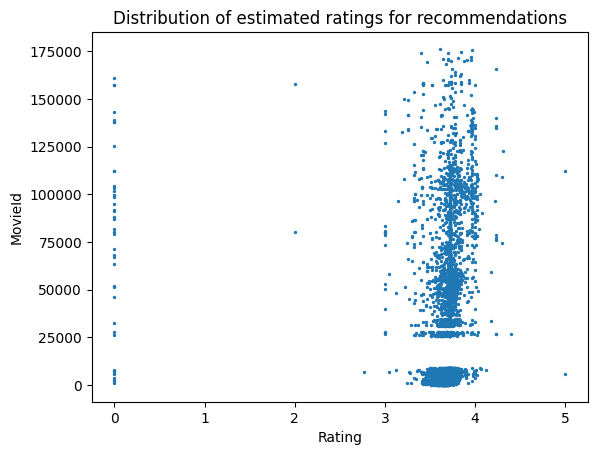

In [ ]:
movieId, est_rating = zip(*recs)
plt.scatter(est_rating, movieId, s = 2)
plt.title("Distribution of estimated ratings for recommendations")
plt.xlabel("Rating")
plt.ylabel("MovieId")
plt.show()

As we can see there is a large number of recommendations that have an estimated rating between 3-4, this is due to a large number of ratings are above 3. As can be seen below only 15% of the ratings, from the ratings dataset are actually below 3. This reflects how many movies are enjoyable, but not great or terrible. This was also shown earlier on the overall movie dataset of how the average rating for movies are always above 5 out 10.

In [ ]:
ratings_3 = len(ratings_filtered.loc[ratings_filtered['rating'] < 3])
ratings_above_3=len(ratings_filtered.loc[ratings_filtered['rating'] >= 3])
print(f"{np.round(ratings_3/(ratings_3 + ratings_above_3),2)*100}%" )

15.0%


We can now integrate clustering into collaborative filtering to unite two components and make our recommendations more focused and accurate. By grouping movies into clusters, we guide the algorithm to compare the user only with movies that share similar characteristics

We match each movie with its cluster by joining our movie table to the cluster table using the TMDB ID. Then we remove any duplicate movies. Then, we create a simple lookup so we can quickly get a movie’s cluster just by using its movieId.

In [ ]:
movies_with_links = movies_with_links.merge(
    df_clean[['id', 'cluster']],
    left_on='tmdbId',
    right_on='id',
    how='left'
)
movies_with_links = movies_with_links.drop_duplicates('movieId', keep='first')
movie_cluster = movies_with_links.set_index('movieId')['cluster']

Finding the user's dominant movie cluster from their top-rated movies

In [ ]:
def get_user_main_cluster(user_id, top_k=3):
    watched, ratings = movies_watched(user_id)

    if len(watched) == 0:
        return None

    triples = []
    for m, r in zip(watched, ratings):
        c = movie_cluster.get(m, None)
        if c is not None:
            triples.append((m, r, c))

    if not triples:
        return None

    triples.sort(key=lambda x: x[1], reverse=True)
    top_triples = triples[:top_k]

    cluster_counts = Counter([t[2] for t in top_triples])
    main_cluster = cluster_counts.most_common(1)[0][0]
    return main_cluster

Collaborative filtering with cluster-based filtering. This function first works by finding the user’s main movie cluster using the developed function and then filters out all unwatched movies that don’t belong to that cluster. It then estimates the user’s rating for each remaining movie, sorts them by predicted score, and returns the top recommendations.

In [ ]:
def collaborative_filtering_recommendations_clustered(user, recommendations):
    base_cluster = get_user_main_cluster(user)

    movies_user_watched = movies_watched(user)[0]

    movie_list = movie_sim_df.drop(movies_user_watched).index.tolist()

    if base_cluster is not None:
        filtered_movie_list = [
            m for m in movie_list
            if movie_cluster.get(m, None) == base_cluster
        ]
        if len(filtered_movie_list) > 0:
            movie_list = filtered_movie_list

    movies = []
    for movie in movie_list:
        est_movie_rating = estimated_rating(user, movie)
        movies.append((movie, est_movie_rating))

    movies_sorted = sorted(movies, key=lambda x: x[1], reverse=True)
    return movies_sorted[:recommendations]

It then allows us to compute predicted ratings for each candidate movie within the user’s dominant cluster, rank these items based on their estimated relevance, and return the highest-rating entries as the final recommendation list.

Example usage of the clustered recommendation system:

In [ ]:
user = 40
recs_clustered = collaborative_filtering_recommendations_clustered(user, 10)
rec_ids = [m for (m, _) in recs_clustered]

movies_with_links[movies_with_links['movieId'].isin(rec_ids)][
    ['movieId', 'title', 'cluster']
]

,movieId,title,cluster
2783,48863,Azumi 2: Death or Love,1.0
3449,73386,Staten Island,1.0
3949,90434,Assassination Games,1.0
4146,96621,Arthur and the Revenge of Maltazard,1.0
4299,100408,Resident Evil: Damnation,1.0
4311,100882,Journey to the West: Conquering the Demons,1.0
4626,107953,Dragon Ball Z: Battle of Gods,1.0
4664,108864,The Prey,1.0
5716,136229,Sanitarium,1.0
6056,144538,Cold War,1.0


# 5) Hybrid Recommendation System

So far we have three separate approaches:
- **LSH** - finds similar movies based on explicit features
- **Clustering** - groups movies by semantic similarity
- **Collaborative Filtering** - leverages user behavior

Each works well in different situations. LSH is fast and interpretable but ignores user history. Clustering captures hidden patterns but doesn't personalize. CF gives personalized recommendations but fails for new users with no ratings.

**The challenge:** How do we recommend when we know nothing about a user vs. when we have rich rating history?

**Our solution:** A hybrid system that adapts based on user activity - relying on content similarity (LSH) for new users and shifting toward collaborative signals for active users.

At first we developoing helper functions, to make final implementation more readable maintainable

Categorizing users based on number of rating

In [ ]:
def get_user_segment(user_id):
    n_ratings = (ratings_filtered['userId'] == user_id).sum()

    if n_ratings < 5:
        return "new"
    elif n_ratings < 50:
        return "mid"
    else:
        return "active"

This function finds content-based recommendations for a given movie title and records the highest similarity score for each related movie.

In [ ]:
def content_scores_from_title(seed_title, top_n=50):

    content_recs = recommend_movies(seed_title, top_n=top_n) # LSH
    scores = {}

    for title, sim in content_recs:
        rows = movies_with_links[movies_with_links['title'] == title]
        for mid in rows['movieId'].tolist():
            scores[mid] = max(scores.get(mid, 0.0), sim)

    return scores

This function finds the user's highest rated movie

In [ ]:
def get_user_favourite_title(user_id):
    watched = movies_watched(user_id)
    if not watched:
        return None

    rows = test_ratings[test_ratings['userId'] == user_id]
    rows = rows.merge(movies_with_links[['movieId', 'title']], on='movieId', how='inner')
    if rows.empty:
        return None

    fav_row = rows.sort_values('rating', ascending=False).iloc[0]
    return fav_row['title']

This function returns a dictionary where each recommended movieId is paired with its predicted rating score.

In [ ]:
def cf_scores_for_user(user_id, top_n=200):
    cf_recs = collaborative_filtering_recommendations_clustered(user_id, top_n) # CF + clustering
    return {mid: score for (mid, score) in cf_recs}

Scaling score between 0 and 1

In [ ]:
def normalize_scores(score_dict):
    if not score_dict:
        return {}
    vals = np.array(list(score_dict.values()), dtype=float)
    vmin, vmax = vals.min(), vals.max()
    if vmax == vmin:
        return {k: 1.0 for k in score_dict}
    return {k: (v - vmin) / (vmax - vmin) for k, v in score_dict.items()}

the final function that generates personalized hybrid recommendations by combining LSH and clustered CF, with different weighting strategies depending on whether the user is new, mid-level, or active.

In [ ]:
def hybrid_recommend(user_id, top_n=10, seed_title_for_new=None):
    """""
    new user: LSH only
    mid user:     mix of LSH + clustered CF
    active user:  mostly clustered CF, some LSH
    """""
    segment = get_user_segment(user_id)
    watched, _ = movies_watched(user_id)
    watched_arr = set(watched)

    final_scores = {}

    # NEW
    if segment == "new":
        # 0 ratings
        if (test_ratings['userId'] == user_id).sum() == 0:
            if seed_title_for_new is None:
                raise ValueError(
                    "Value error"
                )
            seed_title = seed_title_for_new
        else:
            # 1–4 ratings -_-
            seed_title = get_user_favourite_title(user_id)

        content_scores = {}
        if seed_title is not None:
            content_scores = content_scores_from_title(seed_title, top_n=5*top_n)
        content_scores = normalize_scores(content_scores)

        for mid, s in content_scores.items():
            if mid not in watched_arr:
                final_scores[mid] = s  # 100% LSH

    # MID
    elif segment == "mid":
        favourite_title = get_user_favourite_title(user_id)

        # LSH
        content_scores = {}
        if favourite_title is not None:
            content_scores = content_scores_from_title(favourite_title, top_n=5*top_n)
        content_scores = normalize_scores(content_scores)

        # cluster-aware CF
        cf_scores = normalize_scores(cf_scores_for_user(user_id, top_n=5*top_n))

        # weights:
        alpha = 0.6  # content
        beta  = 0.4  # CF

        all_mids = set(content_scores.keys()) | set(cf_scores.keys())

        for mid in all_mids:
            if mid in watched_arr:
                continue
            c = content_scores.get(mid, 0.0)
            f = cf_scores.get(mid, 0.0)
            final_scores[mid] = alpha * c + beta * f

    # ACTIVE
    else:
        favourite_title = get_user_favourite_title(user_id)

        content_scores = {}
        if favourite_title is not None:
            content_scores = content_scores_from_title(favourite_title, top_n=3*top_n)
        content_scores = normalize_scores(content_scores)

        # clustered CF
        cf_scores = normalize_scores(cf_scores_for_user(user_id, top_n=5*top_n))

        # weights:
        alpha = 0.3  # content
        beta  = 0.7  # CF

        all_mids = set(content_scores.keys()) | set(cf_scores.keys())

        for mid in all_mids:
            if mid in watched_arr:
                continue
            c = content_scores.get(mid, 0.0)
            f = cf_scores.get(mid, 0.0)
            final_scores[mid] = alpha * c + beta * f

    if not final_scores:
        return pd.DataFrame(columns=['movieId', 'title', 'cluster', 'score'])

    ranked = sorted(final_scores.items(), key=lambda x: x[1], reverse=True)[:top_n]
    rec_ids = [mid for (mid, _) in ranked]

    rec_df = movies_with_links[movies_with_links['movieId'].isin(rec_ids)][
        ['movieId', 'title', 'cluster']
    ].copy()

    rec_df['score'] = rec_df['movieId'].map(dict(ranked))
    rec_df = rec_df.sort_values('score', ascending=False)

    return rec_df

In [ ]:
hybrid_recommend(user_id=3258, top_n=10)

,movieId,title,cluster,score
40,158,Casper,1.0,0.600000
258,1015,Homeward Bound: The Incredible Journey,3.0,0.466667
2947,54328,My Best Friend,3.0,0.466667
296,1148,The Wrong Trousers,0.0,0.400000
3043,56176,Alvin and the Chipmunks,1.0,0.400000
5265,124919,The Wind in the Willows,3.0,0.400000
5716,136229,Sanitarium,1.0,0.400000
6676,160112,Cell,1.0,0.389865
4146,96621,Arthur and the Revenge of Maltazard,1.0,0.340920
874,3175,Galaxy Quest,1.0,0.333333


It outputs: f.x. if user has 16 ratings, they fall into the “mid” user segment, so the function outputs:

A DataFrame of movie recommendations containing these columns (movieId, movie title, movie's cluster and score - a weighted mix of LSH and CF scores)

The rows are sorted from the highest to lowest score, showing the top recommended movies for that mid-level user.